In [1]:
import uproot as ur
import uproot_methods as urm
import numpy as np
import awkward
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing.sequence import pad_sequences

import tools
from four_jet_network import FourJetNetwork

filename = 'user.jagrundy.20736236._000001.MiniNTuple.root'

print("opening file")
s_table = tools.open_file(filename, sort_by="tag")

Using TensorFlow backend.


opening file
sorting data by tag


# Stage 1, pt classifier

- if 4th jet found, keep selection based on this method
- if not, proceed to stage 2

In [2]:
print("filtering from", len(s_table), "total events")

# filter so we get events with 3 or 4 b-jets, and 3 tags
nb34 = (s_table.nbjets == 3) | (s_table.nbjets == 4) # 3 or 4 b-jets
nj4 = s_table.njets >= 4 # at least 4 jets
nt3 = s_table.nbtags==3  # 3 b-tags
events = s_table[nb34 & nt3 & nj4]

# and ensure that the 3 tags are actually correct
# this results in very little event loss
events = events[events.truth[:,0] == 1]
events = events[events.truth[:,1] == 1]
events = events[events.truth[:,2] == 1]

n_events = len(events)
print(n_events)

filtering from 777150 total events
302694


In [3]:
cutoff = 10  # np.max(events.njets)
padding_val = 0

# pad events out to 'cutoff' events
events = tools.pad(events, cutoff)
# boost/rotate
events = tools.boost_and_rotate(events)

/home/callum/anaconda3/envs/437env/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:181: RuntimeWarning: invalid value encountered in true_divide
  return self._trymemo("eta", lambda self: self.awkward.numpy.arcsinh(self.z / self.awkward.numpy.sqrt(self.x**2 + self.y**2)))


Don't worry if you see a warning about dividing by zero, fixing that!


100%|██████████| 302694/302694 [00:01<00:00, 157078.55it/s]


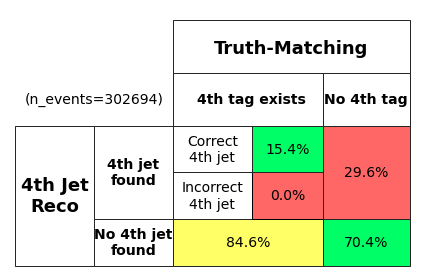

(15.43328007678307,
 0.0,
 84.56671992321694,
 29.57450520774068,
 70.42549479225931)

In [4]:
# separate the 3 first jets from the rest since they're already tagged correctly
# (given our filtering procedure above)
px_3, px_rest = events.resolved_lv.p3.x[:, :3], events.resolved_lv.p3.x[:, 3:]
py_3, py_rest = events.resolved_lv.p3.y[:, :3], events.resolved_lv.p3.y[:, 3:]
# find the best jet from _rest that fits with _3, in terms of pt sum = 0
px_3_sums = np.repeat(np.sum(px_3, axis=1).reshape(-1, 1), cutoff-3, axis=1)
py_3_sums = np.repeat(np.sum(py_3, axis=1).reshape(-1, 1), cutoff-3, axis=1)

px_sums = np.abs(px_rest + px_3_sums)
py_sums = np.abs(py_rest + py_3_sums)

magnitudes = np.sqrt(px_sums**2 + py_sums**2)
lowest_vals = np.min(magnitudes, axis=1)
lowest_indices = np.argmin(magnitudes, axis=1)

# lower values = more certainty
# let's set an arbitrary threshold,
# and say if lowest_val > thresh, pick no jet
thresh = 0.001
lowest_indices[lowest_vals>thresh] = cutoff-3

# also if the event was fine before adding a 4th jet, pick no jet
# this ends up having a small effect
px_sums_no_4th = np.abs(px_3_sums[:,0])
py_sums_no_4th = np.abs(py_3_sums[:,0])
magnitudes_no_4th = np.sqrt(px_sums_no_4th**2 + py_sums_no_4th**2)
lowest_indices[magnitudes_no_4th<thresh] = cutoff-3

# put this in a better format
selection_index = lowest_indices + 3
selections = np.zeros((len(events.truth), cutoff+1), dtype=int)
for i, s in enumerate(selection_index):
    selections[i][s] = 1
# chop off last index so selection = [0,...,0] for no selection
selections = selections[:, :-1]

picked_no_4th = np.sum(selections, axis=1) == 0

# compare to tag_u, truth_u
tools.evaluate_model(events.truth, events.tag, selections)

# Stage 2: The 4-jet NN Gauntlet

- make 4-jet nn
- split events into 4-jet groups
- take best-fit jet in terms of 4-jet nn results

## To make the 4-jet nn, just copy the 4b notebook

Don't worry if you see a warning about dividing by zero, fixing that!
Train on 45749 samples, validate on 6537 samples
Epoch 1/400
45749/45749 [==============================] - 0s 8us/step - loss: 0.6914 - accuracy: 0.5837 - val_loss: 0.6900 - val_accuracy: 0.5851
Epoch 2/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.6846 - accuracy: 0.5939 - val_loss: 0.6835 - val_accuracy: 0.5925
Epoch 3/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.6789 - accuracy: 0.5985 - val_loss: 0.6778 - val_accuracy: 0.5958
Epoch 4/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.6737 - accuracy: 0.6000 - val_loss: 0.6726 - val_accuracy: 0.5972
Epoch 5/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.6688 - accuracy: 0.6008 - val_loss: 0.6677 - val_accuracy: 0.5986
Epoch 6/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.6640 - accuracy: 0.6020 - val_loss: 0.6629 - val_accuracy: 0.5978

45749/45749 [==============================] - 0s 5us/step - loss: 0.5467 - accuracy: 0.7178 - val_loss: 0.5490 - val_accuracy: 0.7138
Epoch 56/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.5458 - accuracy: 0.7178 - val_loss: 0.5482 - val_accuracy: 0.7130
Epoch 57/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.5450 - accuracy: 0.7179 - val_loss: 0.5473 - val_accuracy: 0.7149
Epoch 58/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.5442 - accuracy: 0.7187 - val_loss: 0.5465 - val_accuracy: 0.7153
Epoch 59/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.5434 - accuracy: 0.7186 - val_loss: 0.5457 - val_accuracy: 0.7155
Epoch 60/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.5426 - accuracy: 0.7196 - val_loss: 0.5449 - val_accuracy: 0.7158
Epoch 61/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.5419 - accuracy: 0.7200 - val_loss: 0.5441 

45749/45749 [==============================] - 0s 5us/step - loss: 0.5143 - accuracy: 0.7407 - val_loss: 0.5161 - val_accuracy: 0.7366
Epoch 111/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.5138 - accuracy: 0.7408 - val_loss: 0.5157 - val_accuracy: 0.7372
Epoch 112/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.5134 - accuracy: 0.7416 - val_loss: 0.5152 - val_accuracy: 0.7384
Epoch 113/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.5130 - accuracy: 0.7419 - val_loss: 0.5148 - val_accuracy: 0.7393
Epoch 114/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.5126 - accuracy: 0.7421 - val_loss: 0.5144 - val_accuracy: 0.7396
Epoch 115/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.5121 - accuracy: 0.7426 - val_loss: 0.5140 - val_accuracy: 0.7401
Epoch 116/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.5117 - accuracy: 0.7430 - val_loss: 0

45749/45749 [==============================] - 0s 5us/step - loss: 0.4970 - accuracy: 0.7514 - val_loss: 0.4993 - val_accuracy: 0.7474
Epoch 166/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4968 - accuracy: 0.7516 - val_loss: 0.4991 - val_accuracy: 0.7480
Epoch 167/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4966 - accuracy: 0.7515 - val_loss: 0.4989 - val_accuracy: 0.7484
Epoch 168/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4963 - accuracy: 0.7518 - val_loss: 0.4986 - val_accuracy: 0.7482
Epoch 169/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4961 - accuracy: 0.7518 - val_loss: 0.4984 - val_accuracy: 0.7485
Epoch 170/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4959 - accuracy: 0.7522 - val_loss: 0.4983 - val_accuracy: 0.7487
Epoch 171/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4957 - accuracy: 0.7521 - val_loss: 0

45749/45749 [==============================] - 0s 5us/step - loss: 0.4881 - accuracy: 0.7563 - val_loss: 0.4906 - val_accuracy: 0.7520
Epoch 221/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4880 - accuracy: 0.7565 - val_loss: 0.4905 - val_accuracy: 0.7516
Epoch 222/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4878 - accuracy: 0.7566 - val_loss: 0.4904 - val_accuracy: 0.7519
Epoch 223/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4877 - accuracy: 0.7565 - val_loss: 0.4903 - val_accuracy: 0.7516
Epoch 224/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4876 - accuracy: 0.7568 - val_loss: 0.4902 - val_accuracy: 0.7519
Epoch 225/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4875 - accuracy: 0.7568 - val_loss: 0.4901 - val_accuracy: 0.7517
Epoch 226/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4874 - accuracy: 0.7568 - val_loss: 0

45749/45749 [==============================] - 0s 5us/step - loss: 0.4829 - accuracy: 0.7587 - val_loss: 0.4860 - val_accuracy: 0.7574
Epoch 276/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4828 - accuracy: 0.7587 - val_loss: 0.4860 - val_accuracy: 0.7577
Epoch 277/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4827 - accuracy: 0.7588 - val_loss: 0.4859 - val_accuracy: 0.7575
Epoch 278/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4826 - accuracy: 0.7584 - val_loss: 0.4859 - val_accuracy: 0.7578
Epoch 279/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4826 - accuracy: 0.7584 - val_loss: 0.4858 - val_accuracy: 0.7577
Epoch 280/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4825 - accuracy: 0.7587 - val_loss: 0.4857 - val_accuracy: 0.7580
Epoch 281/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4824 - accuracy: 0.7588 - val_loss: 0

45749/45749 [==============================] - 0s 5us/step - loss: 0.4791 - accuracy: 0.7612 - val_loss: 0.4828 - val_accuracy: 0.7594
Epoch 331/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4790 - accuracy: 0.7613 - val_loss: 0.4827 - val_accuracy: 0.7601
Epoch 332/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4789 - accuracy: 0.7616 - val_loss: 0.4826 - val_accuracy: 0.7597
Epoch 333/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4789 - accuracy: 0.7617 - val_loss: 0.4826 - val_accuracy: 0.7598
Epoch 334/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4788 - accuracy: 0.7612 - val_loss: 0.4826 - val_accuracy: 0.7595
Epoch 335/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4787 - accuracy: 0.7615 - val_loss: 0.4825 - val_accuracy: 0.7597
Epoch 336/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4787 - accuracy: 0.7613 - val_loss: 0

45749/45749 [==============================] - 0s 5us/step - loss: 0.4760 - accuracy: 0.7636 - val_loss: 0.4800 - val_accuracy: 0.7609
Epoch 386/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4759 - accuracy: 0.7633 - val_loss: 0.4800 - val_accuracy: 0.7609
Epoch 387/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4759 - accuracy: 0.7634 - val_loss: 0.4799 - val_accuracy: 0.7607
Epoch 388/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4758 - accuracy: 0.7636 - val_loss: 0.4798 - val_accuracy: 0.7614
Epoch 389/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4758 - accuracy: 0.7636 - val_loss: 0.4798 - val_accuracy: 0.7615
Epoch 390/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4757 - accuracy: 0.7639 - val_loss: 0.4797 - val_accuracy: 0.7617
Epoch 391/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4757 - accuracy: 0.7640 - val_loss: 0

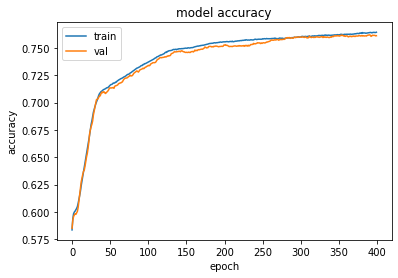

In [5]:
# filter so we get events with 4 jets, 3 or 4 b-jets, and 3 tags
j4 = (s_table.njets == 4) # 4 jets
b34 = (s_table.nbjets == 3) | (s_table.nbjets == 4) # 3 or 4 b-jets
nt3 = s_table.nbtags==3  # 3 b-tags
events_4j = s_table[j4 & b34 & nt3]
events_4j = events_4j[events_4j.truth[:,0] == 1]
events_4j = events_4j[events_4j.truth[:,1] == 1]
events_4j = events_4j[events_4j.truth[:,2] == 1]
# pad, boost, rotate
events_4j = tools.pad(events_4j, length=4)
events_4j = tools.boost_and_rotate(events_4j)
# create network
nn = FourJetNetwork(events_4j)
nn.learn()
#nn.evaluate()

In [6]:
# the network score for some events is given by
def score(nn, evs):
    """Note: this expects evs to be events of 4 jets"""
    nn_input = tools.scale_nn_input(evs)
    nn_score = nn.model.predict(nn_input)
    return nn_score.flatten()

1661359
Train on 1162951 samples, validate on 166137 samples
Epoch 1/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.4326 - accuracy: 0.7971 - val_loss: 0.5718 - val_accuracy: 0.7514
Epoch 2/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.2252 - accuracy: 0.9118 - val_loss: 0.5294 - val_accuracy: 0.7427
Epoch 3/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.2060 - accuracy: 0.9112 - val_loss: 0.5110 - val_accuracy: 0.7460
Epoch 4/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1986 - accuracy: 0.9118 - val_loss: 0.5030 - val_accuracy: 0.7466
Epoch 5/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1948 - accuracy: 0.9120 - val_loss: 0.4975 - val_accuracy: 0.7482
Epoch 6/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1922 - accuracy: 0.9126 - val_loss: 0.4929 - val_accuracy: 0.7502
Epoch 7/300
1162951/1162951 [====

1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1695 - accuracy: 0.9264 - val_loss: 0.4359 - val_accuracy: 0.7944
Epoch 55/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1694 - accuracy: 0.9264 - val_loss: 0.4356 - val_accuracy: 0.7941
Epoch 56/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1693 - accuracy: 0.9264 - val_loss: 0.4356 - val_accuracy: 0.7944
Epoch 57/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1692 - accuracy: 0.9265 - val_loss: 0.4350 - val_accuracy: 0.7944
Epoch 58/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1691 - accuracy: 0.9264 - val_loss: 0.4348 - val_accuracy: 0.7942
Epoch 59/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1690 - accuracy: 0.9265 - val_loss: 0.4346 - val_accuracy: 0.7942
Epoch 60/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1689 - accuracy

Epoch 108/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1634 - accuracy: 0.9281 - val_loss: 0.4187 - val_accuracy: 0.8001
Epoch 109/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1633 - accuracy: 0.9282 - val_loss: 0.4182 - val_accuracy: 0.8004
Epoch 110/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1631 - accuracy: 0.9282 - val_loss: 0.4176 - val_accuracy: 0.8009
Epoch 111/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1630 - accuracy: 0.9283 - val_loss: 0.4174 - val_accuracy: 0.8007
Epoch 112/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1629 - accuracy: 0.9283 - val_loss: 0.4172 - val_accuracy: 0.8010
Epoch 113/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1628 - accuracy: 0.9284 - val_loss: 0.4167 - val_accuracy: 0.8012
Epoch 114/300
1162951/1162951 [==============================] - 6s 5us/step - los

1162951/1162951 [==============================] - 6s 6us/step - loss: 0.1603 - accuracy: 0.9296 - val_loss: 0.4097 - val_accuracy: 0.8059
Epoch 162/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1602 - accuracy: 0.9296 - val_loss: 0.4096 - val_accuracy: 0.8061
Epoch 163/300
1162951/1162951 [==============================] - 6s 6us/step - loss: 0.1602 - accuracy: 0.9296 - val_loss: 0.4098 - val_accuracy: 0.8058
Epoch 164/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1602 - accuracy: 0.9296 - val_loss: 0.4095 - val_accuracy: 0.8059
Epoch 165/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1602 - accuracy: 0.9296 - val_loss: 0.4095 - val_accuracy: 0.8060
Epoch 166/300
1162951/1162951 [==============================] - 6s 6us/step - loss: 0.1601 - accuracy: 0.9296 - val_loss: 0.4094 - val_accuracy: 0.8058
Epoch 167/300
1162951/1162951 [==============================] - 7s 6us/step - loss: 0.1601 - ac

1162951/1162951 [==============================] - 6s 6us/step - loss: 0.1590 - accuracy: 0.9301 - val_loss: 0.4060 - val_accuracy: 0.8078
Epoch 215/300
1162951/1162951 [==============================] - 6s 6us/step - loss: 0.1590 - accuracy: 0.9301 - val_loss: 0.4060 - val_accuracy: 0.8084
Epoch 216/300
1162951/1162951 [==============================] - 6s 6us/step - loss: 0.1590 - accuracy: 0.9301 - val_loss: 0.4058 - val_accuracy: 0.8083
Epoch 217/300
1162951/1162951 [==============================] - 6s 6us/step - loss: 0.1589 - accuracy: 0.9301 - val_loss: 0.4058 - val_accuracy: 0.8082
Epoch 218/300
1162951/1162951 [==============================] - 6s 6us/step - loss: 0.1589 - accuracy: 0.9301 - val_loss: 0.4059 - val_accuracy: 0.8084
Epoch 219/300
1162951/1162951 [==============================] - 6s 6us/step - loss: 0.1589 - accuracy: 0.9301 - val_loss: 0.4056 - val_accuracy: 0.8085
Epoch 220/300
1162951/1162951 [==============================] - 6s 6us/step - loss: 0.1589 - ac

1162951/1162951 [==============================] - 6s 6us/step - loss: 0.1579 - accuracy: 0.9306 - val_loss: 0.4030 - val_accuracy: 0.8097
Epoch 268/300
1162951/1162951 [==============================] - 6s 6us/step - loss: 0.1579 - accuracy: 0.9306 - val_loss: 0.4030 - val_accuracy: 0.8099
Epoch 269/300
1162951/1162951 [==============================] - 6s 6us/step - loss: 0.1579 - accuracy: 0.9305 - val_loss: 0.4029 - val_accuracy: 0.8099
Epoch 270/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1578 - accuracy: 0.9306 - val_loss: 0.4027 - val_accuracy: 0.8100
Epoch 271/300
1162951/1162951 [==============================] - 6s 6us/step - loss: 0.1578 - accuracy: 0.9306 - val_loss: 0.4029 - val_accuracy: 0.8098
Epoch 272/300
1162951/1162951 [==============================] - 6s 6us/step - loss: 0.1578 - accuracy: 0.9307 - val_loss: 0.4026 - val_accuracy: 0.8097
Epoch 273/300
1162951/1162951 [==============================] - 6s 6us/step - loss: 0.1578 - ac

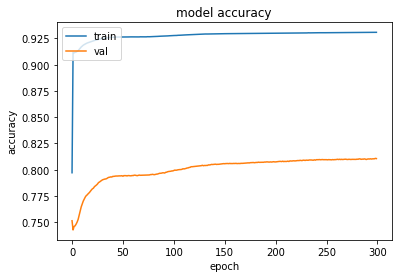

In [7]:
scores = np.zeros((len(events), cutoff), dtype=float)

# each group has this size
group_len = len(events.truth[picked_no_4th])

group_events = awkward.Table()
group_events.truth = np.concatenate([events.truth[picked_no_4th][:,[0,1,2,i]] for i in range(3, cutoff)])
group_events.tag = np.concatenate([events.tag[picked_no_4th][:,[0,1,2,i]] for i in range(3, cutoff)])
pt = np.concatenate([events.resolved_lv.pt[picked_no_4th][:,[0,1,2,i]] for i in range(3, cutoff)])
eta = np.concatenate([events.resolved_lv.eta[picked_no_4th][:,[0,1,2,i]] for i in range(3, cutoff)])
phi = np.concatenate([events.resolved_lv.phi[picked_no_4th][:,[0,1,2,i]] for i in range(3, cutoff)])
E = np.concatenate([events.resolved_lv.E[picked_no_4th][:,[0,1,2,i]] for i in range(3, cutoff)])
group_events.resolved_lv = urm.TLorentzVectorArray.from_ptetaphie(
    pt, eta, phi, E)
print(len(group_events.truth))
group_nn = FourJetNetwork(group_events)
group_nn.learn(epochs=300)
#group_nn.evaluate()

In [8]:
group_scores = score(group_nn, group_events)
print(group_scores.shape)
group_scores = group_scores.reshape((group_len, cutoff-3))

(1661359,)


In [9]:
maxes = np.max(group_scores, axis=1)
select = np.argmax(group_scores,axis=1)
select[maxes < 0.5] = cutoff
nn_selections = np.zeros((len(select), cutoff+1), dtype=int)
for i, s in enumerate(select):
    nn_selections[i][s] = 1

# chop off the last "no selection" jet
nn_selections = nn_selections[:,:-1]

# and actually evaluate
#tools.evaluate_model(events.truth[picked_no_4th], events.tag[picked_no_4th], nn_selections)

100%|██████████| 302694/302694 [00:02<00:00, 147973.30it/s]


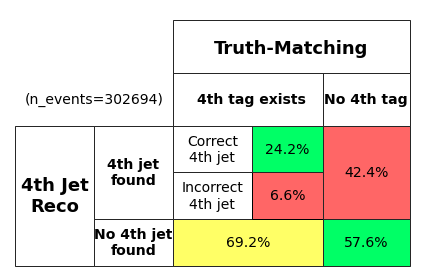

(24.18549666122397,
 6.620784100286181,
 69.19371923848986,
 42.429621537971364,
 57.57037846202862)

In [10]:
# edit the selections from earlier
selections[picked_no_4th] = nn_selections
tools.evaluate_model(events.truth, events.tag, selections)